1. Sentiment Scoring with VADER

In [1]:
# Sentiment Scoring with VADER

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np

# Load the cleaned news data from Task 1
NEWS_FILE = r'C:\Users\Home-User\challenge-week1\data\cleaned_financial_news.csv'
news_df = pd.read_csv(NEWS_FILE)
news_df['publication_date'] = pd.to_datetime(news_df['publication_date']).dt.date # Convert back to date object for joining

# Initialize VADER and optionally update for finance terms (as noted in Search)
vader = SentimentIntensityAnalyzer()
# Optional: Update lexicon for financial context (Example: 'crushes': 10, 'misses': -5)
new_words = {'beats': 3.0, 'misses': -3.0, 'raises': 2.0, 'cuts': -2.0}
vader.lexicon.update(new_words)

# Apply VADER to get the Compound Sentiment Score
news_df['sentiment_score'] = news_df['headline'].apply(
    lambda x: vader.polarity_scores(str(x))['compound']
)

print(f"Sentiment scoring complete. Sample:\n{news_df[['headline', 'sentiment_score']].head()}")

Sentiment scoring complete. Sample:
                                            headline  sentiment_score
0            Stocks That Hit 52-Week Highs On Friday           0.0000
1         Stocks That Hit 52-Week Highs On Wednesday           0.0000
2                      71 Biggest Movers From Friday           0.0000
3       46 Stocks Moving In Friday's Mid-Day Session           0.0000
4  B of A Securities Maintains Neutral on Agilent...           0.6369


2. Data Aggregation and Merging

In [2]:
#Data Aggregation and Merging

# 1. Aggregate News Sentiment
# Calculate the mean sentiment score for each stock on each day
daily_sentiment = news_df.groupby(['publication_date', 'stock_symbol'])['sentiment_score'].mean().reset_index()
daily_sentiment.rename(columns={'stock_symbol': 'Ticker', 'publication_date': 'Date'}, inplace=True)
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# 2. Load Stock Data
STOCK_FILE = r'C:\Users\Home-User\challenge-week1\data\all_tickers_indicators.csv'
stock_df = pd.read_csv(STOCK_FILE, index_col='Date', parse_dates=True)
stock_df.reset_index(inplace=True)

# 3. Merge
# Join the aggregated sentiment to the stock data on Date and Ticker
# Use an inner join to only keep days where both news and stock data exist
final_df = pd.merge(
    stock_df,
    daily_sentiment,
    on=['Date', 'Ticker'],
    how='inner'
)

print(f"\nMerged Data Shape: {final_df.shape}")
print(f"Merged columns:\n{final_df.columns.tolist()}")


Merged Data Shape: (13, 15)
Merged columns:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Daily_Return', 'SMA_20', 'EMA_50', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist', 'sentiment_score']


3. Correlation Analysis and Visualization


--- Overall Sentiment-Return Correlation (Pearson): 0.2058 ---


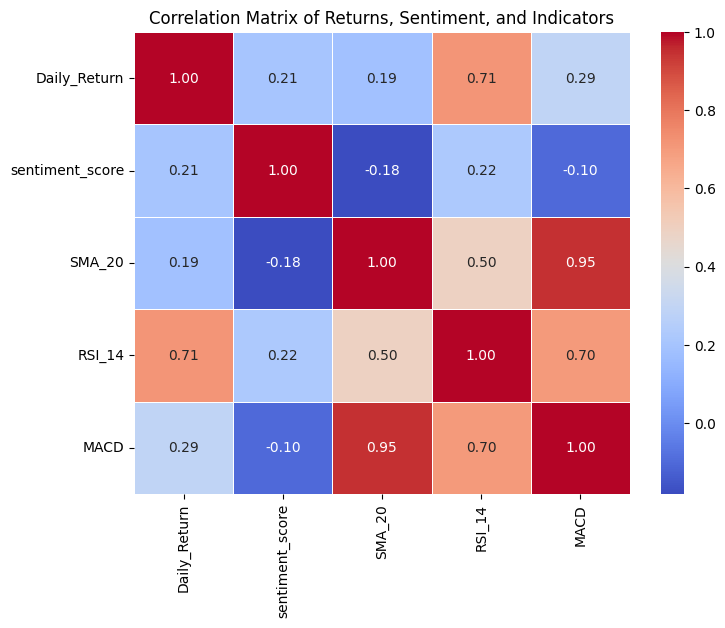


--- Sentiment-Return Correlation Per Ticker ---
        Sentiment_Return_Correlation
Ticker                              
NVDA                        0.522731
GOOG                       -0.234365
AAPL                       -1.000000
AMZN                       -1.000000


In [4]:
#Correlation Analysis and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# A. Overall Correlation
overall_correlation = final_df[['Daily_Return', 'sentiment_score']].corr().iloc[0, 1]
print(f"\n--- Overall Sentiment-Return Correlation (Pearson): {overall_correlation:.4f} ---")

# B. Correlation Matrix (for all variables)
# We focus on how Daily_Return correlates with the new Sentiment score and the TA indicators
correlation_matrix = final_df[['Daily_Return', 'sentiment_score', 'SMA_20', 'RSI_14', 'MACD']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Returns, Sentiment, and Indicators')
plt.show()

# C. Correlation Per Ticker (The most granular and actionable insight)
ticker_correlations = final_df.groupby('Ticker')[['Daily_Return', 'sentiment_score']].corr().unstack().iloc[:, 1]
ticker_correlations.rename('Sentiment_Return_Correlation', inplace=True)

print("\n--- Sentiment-Return Correlation Per Ticker ---")
print(ticker_correlations.sort_values(ascending=False).to_frame())

Investment Strategy: Sentiment-Weighted MomentumThe strategy combines the weak positive signal from sentiment with the confirmed trend signals from the technical indicators.Sentiment Filter: Identify days where the Aggregated Daily Sentiment Score for a specific stock exceeds a positive threshold (e.g., Sentiment > 0.5).Trend Confirmation (Entry Signal): Of the stocks passing the sentiment filter, only take a BUY position if a technical indicator confirms a bullish trend, such as:MACD Crossover: MACD line crosses above the MACD Signal line.Moving Average Crossover: Close Price is above the SMA_20.Risk Management (Exit Signal): Close the position if the stock price drops below the SMA_20 (acting as a trailing stop-loss) or if the RSI_14 exceeds 70 (indicating overbought conditions).